In [29]:
# brain_rsa -nif beta_rh_all_run.nii.gz -bmask VTC_mask_rh.nii.gz -metric correlation -out beta_rh_VTC.rdm.h5

from scipy.stats import zscore
from scipy.spatial.distance import pdist

In [30]:
# load brainimg

import nibabel as nib
import numpy as np
import h5py
import os

def load_brainimg(imgpath, ismask=False):
        
    brain_img = nib.load(imgpath).get_fdata()
    if not ismask:
        print(brain_img.shape)
        brain_img = np.transpose(brain_img,(3,0,1,2))
    header = nib.load(imgpath).header
   
    return brain_img, header
    

In [31]:
# RDM structure 


class RdmFile:
    """
    A class to read/write representation distance matrices (RDMs) from/to .rdm.h5 file.
    For saving time and space, DNNBrain only hold on the upper triangle of each RDM.
    We can use np.tri(n_item, k=-1, dtype=np.bool).T to get the index array of the upper triangle.
    The index array can help us to restore RDM from the upper triangle whose shape is ((n_item^2-n_item)/2,).
    """

    def __init__(self, fname):
        """
        Parameters
        ----------
        fname : str
            File name with suffix as .rdm.h5
        """
        assert fname.endswith('.rdm.h5'), "the file's suffix must be .rdm.h5"
        self.fname = fname

    def read(self):
        """
        Read RDMs from .rdm.h5 file

        Returns
        -------
        rdm_type : str
            Choices=(bRDM, dRDM)
            bRDM: RDM for brain activation
            dRDM: RDM for DNN activation
        rdm_dict : dict
            A dict containing the RDM information
                
            +-----------+-------------------------+-----------------------------------------------------+
            |  RDM type |        Keys             |                Values                               |
            +===========+=========================+=====================================================+
            |    bRDM   |  Labels of brain ROIs   |  Arrays with shape as ((n_item^2-n_item)/2,)        |                                 
            +-----------+-------------------------+-----------------------------------------------------+
            |    dRDM   |  Layer names            |  Arrays with shape as (n_iter, (n_item^2-n_item)/2) |
            +-----------+-------------------------+-----------------------------------------------------+
        """
        rf = h5py.File(self.fname, 'r')

        # check
        rdm_type = rf.attrs['type']
        if rdm_type == 'bRDM':
            for v in rf.values():
                assert v.ndim == 1, "bRDM's shape must be ((n_item^2-n_item)/2,)"
        elif rdm_type == 'dRDM':
            for v in rf.values():
                assert v.ndim == 2, "dRDM's shape must be (n_iter, (n_item^2-n_item)/2)"
        else:
            raise TypeError("RDM type must be one of (bRDM, dRDM)")

        # get data
        rdm_dict = dict()
        for k, v in rf.items():
            rdm_dict[k] = v[:]

        rf.close()
        return rdm_type, rdm_dict

    def write(self, rdm_type, rdm_dict):
        """
        write RDMs to .rdm.h5 file

        Parameters
        ----------
        rdm_type : str
            Choices=(bRDM, dRDM)
            bRDM: RDM for brain activation
            dRDM: RDM for DNN activation
        rdm_dict : dict
            A dict containing the RDM information
                
            +-----------+-------------------------+-----------------------------------------------------+
            |  RDM type |        Keys             |                Values                               |
            +===========+=========================+=====================================================+
            |    bRDM   |  Labels of brain ROIs   |  Arrays with shape as ((n_item^2-n_item)/2,)        |                                 
            +-----------+-------------------------+-----------------------------------------------------+
            |    dRDM   |  Layer names            |  Arrays with shape as (n_iter, (n_item^2-n_item)/2) |
            +-----------+-------------------------+-----------------------------------------------------+
        """
        # check
        if rdm_type == 'bRDM':
            for v in rdm_dict.values():
                assert v.ndim == 1, "bRDM's shape must be ((n_item^2-n_item)/2,)"
        elif rdm_type == 'dRDM':
            for v in rdm_dict.values():
                assert v.ndim == 2, "dRDM's shape must be (n_iter, (n_item^2-n_item)/2)"
        else:
            raise TypeError("RDM type must be one of (bRDM, dRDM)")

        # write
        wf = h5py.File(self.fname, 'w')
        wf.attrs['type'] = rdm_type
        for k, v in rdm_dict.items():
            wf.create_dataset(k, data=v, compression='gzip')
        wf.close()

class RDM:
    """
    Representation distance matrix
    """
    def __init__(self):
        self.rdm_type = None
        self._rdm_dict = dict()

    def load(self, fname):
        """
        load RDM
        
        Parameters
        ----------
        fname : str
            File name with suffix as .rdm.h5
        """
        self.rdm_type, self._rdm_dict = RdmFile(fname).read()

    def save(self, fname):
        """
        Save RDM
        
        Parameters
        ----------
        fname : str
            File name with suffix as .rdm.h5
        """
        RdmFile(fname).write(self.rdm_type, self._rdm_dict)

    def get(self, key, triu=False):
        """
        Get RDM according its key.

        Parameters
        ----------
        key : str
            The key of the RDM
        triu : bool
            If True, get RDM as the upper triangle vector.
            If False, get RDM as the square matrix.

        Returns
        -------
        rdm_arr : ndarray
            RDM
            
            If rdm_type is bRDM:
            Its shape is ((n_item^2-n_item)/2,) or (n_item, n_item).
            
            If rdm_type is dRDM:
            Its shape is (n_iter, (n_item^2-n_item)/2) or (n_iter, n_item, n_item).
        """
        rdm_arr = self._rdm_dict[key]
        if not triu:
            idx_arr = np.tri(self.n_item, k=-1, dtype=np.bool).T
            if self.rdm_type == 'bRDM':
                rdm_tmp = np.zeros((self.n_item, self.n_item))
                rdm_tmp[idx_arr] = rdm_arr
            elif self.rdm_type == 'dRDM':
                rdm_tmp = np.zeros((rdm_arr.shape[0], self.n_item, self.n_item))
                rdm_tmp[:, idx_arr] = rdm_arr
            else:
                raise TypeError("Set rdm_type to bRDM or dRDM at first!")
            rdm_arr = rdm_tmp

        return rdm_arr

    def set(self, key, rdm_arr, triu=False):
        """
        Set RDM according its key.

        Parameters
        ----------
        key : str
            The key of the RDM
        rdm_arr : ndarray
            RDM
            
            If rdm_type is bRDM:
            Its shape is ((n_item^2-n_item)/2,) or (n_item, n_item).
            
            If rdm_type is dRDM:
            Its shape is (n_iter, (n_item^2-n_item)/2) or (n_iter, n_item, n_item).
        triu : bool
            If True, RDM will be regarded as the upper triangle vector.
            If False, RDM will be regarded as the square matrix.
        """
        if self.rdm_type == 'bRDM':
            if triu:
                assert rdm_arr.ndim == 1, \
                    "If triu is True, bRDM's shape must be ((n_item^2-n_item)/2,)."
                self._rdm_dict[key] = rdm_arr
            else:
                assert rdm_arr.ndim == 2 and rdm_arr.shape[0] == rdm_arr.shape[1], \
                    "If triu is False, bRDM's shape must be (n_item, n_item)."
                self._rdm_dict[key] = rdm_arr[np.tri(rdm_arr.shape[0], k=-1, dtype=np.bool).T]
        elif self.rdm_type == 'dRDM':
            if triu:
                assert rdm_arr.ndim == 2, \
                    "If triu is True, dRDM's shape must be (n_iter, (n_item^2-n_item)/2)."
                self._rdm_dict[key] = rdm_arr
            else:
                assert rdm_arr.ndim == 3 and rdm_arr.shape[1] == rdm_arr.shape[2], \
                    "If triu is False, dRDM's shape must be (n_iter, n_item, n_item)."
                self._rdm_dict[key] = rdm_arr[:, np.tri(rdm_arr.shape[1], k=-1, dtype=np.bool).T]
        else:
            raise TypeError("Set rdm_type to bRDM or dRDM at first!")

    @property
    def keys(self):
        """
        Get keys of RDM dictionary

        Returns
        -------
        keys : list
            The list of keys
        """
        if self._rdm_dict:
            keys = list(self._rdm_dict.keys())
        else:
            raise ValueError("The RDM dictionary is empty.")

        return keys

    @property
    def n_item(self):
        """
        Get the number of items of RDM

        Returns
        -------
        n_item : int
            The number of items
        """
        k = self.keys[0]
        if self.rdm_type == 'bRDM':
            n = self._rdm_dict[k].shape[0]
        elif self.rdm_type == 'dRDM':
            n = self._rdm_dict[k].shape[1]
        else:
            raise TypeError("Set rdm_type to bRDM or dRDM at first!")
        n_item = int((1 + np.sqrt(1+8*n)) / 2)

        return n_item

In [32]:
# Stimulus

from collections import OrderedDict
from copy import deepcopy
import random


class StimulusFile:
    """
    A class to read and write stimulus file 
    """
    def __init__(self, fname):
        """
        Parameters
        ----------
        fname : str
            pre-designed .stim.csv file.
            
        Format of .stim.csv of image stimuli is
        --------------------------
        type=image
        path=parent_dir_to_images
        [Several optional keys] (eg., title=image stimuli)
        data=stimID,[onset],[duration],[label],[condition],acc,RT
        pic1_name,0,1,0,cat,0.4,0.5
        pic2_name,1,1,1,dog,0.6,0.4
        pic3_name,2,1,0,cat,0.7,0.5
        ...,...,...,...,...,...

        Format of .stim.csv of video stimuli is
        --------------------------
        type=video
        path=path_of_video_file
        [Several optional keys] (eg., title=video stimuli)
        data=stimID,[onset],[duration],[label],[condition],acc,RT
        1,0,1,0,cat,0.4,0.5
        2,1,1,1,dog,0.6,0.4
        3,2,1,0,cat,0.7,0.5
        ...,...,...,...,...,...

        Format of .stim.csv of video_clips stimuli is
        --------------------------
        type=video_clip
        path=parent_dir_to_video_clips
        [Several optional keys] (eg., title=video_clip stimuli)
        data=stimID,[label],[condition]
        clip1_name,0,cat
        clip2_name,1,dog
        clip3_name,0,cat
        ...,...,...,...,...,...
        """
        assert fname.endswith('.stim.csv'), "File suffix must be .stim.csv"
        self.fname = fname
        
    def read(self):
        """
        Returns
        -------
        stimuli : OrderedDict
            Dictionary of the stimuli information
        """
        # -load csv data-
        with open(self.fname) as rf:
            lines = rf.read().splitlines()
        # remove null line
        while '' in lines:
            lines.remove('')
        data_idx = [line.startswith('data=') for line in lines].index(True)
        meta_lines = lines[:data_idx]
        var_lines = lines[data_idx+1:]

        # -handle csv data-
        # --operate meta_lines--
        stimuli = {}
        for line in meta_lines:
            k, v = line.split('=')
            stimuli[k] = v
        assert 'type' in stimuli.keys(), "'type' needs to be included in meta data."
        assert 'path' in stimuli.keys(), "'path' needs to be included in meta data."
        assert stimuli['type'] in ('image', 'video', 'video_clip'), 'not supported type: {}'.format(stimuli['type'])

        # --operate var_lines--
        # prepare keys
        data_keys = lines[data_idx].split('=')[1].split(',')
        assert 'stimID' in data_keys, "'stimID' must be included in 'data=' line."

        # prepare variable data
        var_data = [line.split(',') for line in var_lines]
        var_data = list(zip(*var_data))

        # fill variable data
        data = OrderedDict()
        for idx, key in enumerate(data_keys):
            if key == 'stimID':
                if stimuli['type'] in ('image', 'video_clip'):
                    dtype = np.str_
                else:
                    var_data[idx] = np.float64(var_data[idx])
                    dtype = np.int
            elif key == 'label':
                var_data[idx] = np.float64(var_data[idx])
                dtype = np.int
            elif key == 'condition':
                dtype = np.str_
            else:
                dtype = np.float
            data[key] = np.asarray(var_data[idx], dtype=dtype)
        stimuli['data'] = data

        return stimuli
    
    def write(self, type, path, data, **opt_meta):
        """
        Parameters
        ----------
        type : str
            Stimulus type in ('image', 'video', 'video_clip')
        path : str
            Path_to_stimuli.
            
            If type is 'image', the path is the parent directory of the images.
            If type is 'video', the path is the file name of the video.
            If type is 'video_clip', the path is the parent directory of the video clips.
        data : dict
            Stimulus variable data
        opt_meta : dict
            Some other optional meta data
        """
        with open(self.fname, 'w') as wf:
            # write the type and path
            wf.write('type={}\n'.format(type))
            wf.write('path={}\n'.format(path))

            # write optional meta data
            for k, v in opt_meta.items():
                wf.write('{0}={1}\n'.format(k, v))

            # write variable data
            wf.write('data={}\n'.format(','.join(data.keys())))
            var_data = np.array(list(data.values())).astype(np.str_).T
            var_data = [','.join(row) for row in var_data]
            wf.write('\n'.join(var_data))

class Stimulus:
    """
    Store and handle stimulus-related information
    """
    def __init__(self, header=None, data=None):
        """
        Parameters
        ----------
        header : dict
            Meta-information of stimuli
        data : dict
            Stimulus/behavior data.
            Its values are arrays with shape as (n_stim,).
            It must have the key 'stimID'.
        """
        if header is None:
            self.header = dict()
        else:
            assert isinstance(header, dict), "header must be dict"
            self.header = header

        if data is None:
            self._data = dict()
        else:
            n_stim = len(data['stimID'])
            for v in data.values():
                assert isinstance(v, np.ndarray), "data's value must be an array."
                assert v.shape == (n_stim,), "data's value must be an array with shape as (n_stim,)"
            self._data = data

    def load(self, fname):
        """
        Load stimulus-related information

        Parameters
        ----------
        fname : str
            File name with suffix as .stim.csv
        """
        stim_file = StimulusFile(fname)
        stimuli = stim_file.read()
        self._data = stimuli.pop('data')
        self.header = stimuli

    def save(self, fname):
        """
        Save stimulus-related information

        Parameters
        ----------
        fname : str
            File name with suffix as .stim.csv
        """
        stim_file = StimulusFile(fname)
        header = self.header.copy()
        stim_file.write(header.pop('type'), header.pop('path'),
                        self._data, **header)

    def get(self, item):
        """
        Get a column of data according to the item

        Parameters
        ----------
        item : str
            Item name of each column

        Returns
        -------
        col : array
            A column of data
        """
        return self._data[item]

    def set(self, item, value):
        """
        Set a column of data according to the item

        Parameters
        ----------
        item : str 
            Item name of the column
        value : array_like
            An array_like data with shape as (n_stim,)
        """
        self._data[item] = np.asarray(value)

    def delete(self, item):
        """
        Delete a column of data according to item

        Parameters
        ----------
        item : str
            Item name of each column
        """
        self._data.pop(item)

    def permutate(self, item):
        """
        Permutate a column of data according to the item

        Parameters
        ----------
        item : str
            Item name of the column

        Returns
        -------
        stim : Stimulus
            A copy of the current instance of Stimulus
            except for the permutation on the specified column.
        """
        indices = list(range(len(self._data['stimID'])))
        random.shuffle(indices)

        stim = Stimulus()
        stim.header = deepcopy(self.header)
        stim.set(item, self.get(item)[indices])
        items = self.items
        items.remove(item)
        for item in items:
            stim.set(item, deepcopy(self.get(item)))

        return stim

    @property
    def items(self):
        """
        Get list of items

        Returns
        -------
        items : list
            The list of items
        """
        return list(self._data.keys())

    def __len__(self):
        """
        the length of the Stimulus object

        Returns
        -------
        length : int
            The number of stimulus IDs
        """
        return len(self._data['stimID'])

    def __getitem__(self, indices):
        """
        Get part of the Stimulus object by imitating 2D array's subscript index

        Parameters
        ----------
        indices : int,list,tuple,slice
            Subscript indices

        Returns
        -------
        stim : Stimulus
            A part of the self.
        """
        # parse subscript indices
        if isinstance(indices, int):
            # regard it as row index
            # get all columns
            rows = [indices]
            cols = self.items
        elif isinstance(indices, (slice, list)):
            # regard it all as row indices
            # get all columns
            rows = indices
            cols = self.items
        elif isinstance(indices, tuple):
            if len(indices) == 0:
                # get all rows and columns
                rows = slice(None, None, None)
                cols = self.items
            elif len(indices) == 1:
                # regard the only element as row indices
                # get all columns
                if isinstance(indices[0], int):
                    # regard it as row index
                    rows = [indices[0]]
                elif isinstance(indices[0], (slice, list)):
                    # regard it all as row indices
                    rows = indices[0]
                else:
                    raise IndexError("only integer, slices (`:`), list are valid row indices")
                cols = self.items
            elif len(indices) == 2:
                # regard the first element as row indices
                # regard the second element as column indices
                rows, cols = indices
                if isinstance(rows, int):
                    # regard it as row index
                    rows = [rows]
                elif isinstance(rows, (slice, list)):
                    # regard it all as row indices
                    pass
                else:
                    raise IndexError("only integer, slices (`:`), list are valid row indices")

                if isinstance(cols, int):
                    # get a column according to an integer
                    cols = [self.items[cols]]
                elif isinstance(cols, str):
                    # get a column according to an string
                    cols = [cols]
                elif isinstance(cols, list):
                    if np.all([isinstance(i, int) for i in cols]):
                        # get columns according to a list of integers
                        cols = [self.items[i] for i in cols]
                    elif np.all([isinstance(i, str) for i in cols]):
                        # get columns according to a list of strings
                        pass
                    else:
                        raise IndexError("only integer [list], string [list] and slices (`:`) "
                                         "are valid column indices")
                elif isinstance(cols, slice):
                    # get columns according to a slice
                    cols = self.items[cols]
                else:
                    raise IndexError("only integer [list], string [list] and slices (`:`) "
                                     "are valid column indices")
            else:
                raise IndexError("This is a 2D data, "
                                 "and can't support more than 3 subscript indices!")
        else:
            raise IndexError("only integer, slices (`:`), list and tuple are valid indices")

        # get part of self
        stim = Stimulus()
        stim.header = deepcopy(self.header)
        for item in cols:
            stim.set(item, self.get(item)[rows])

        return stim


In [33]:
# Vars

nifti_path = "data/beta_rh_all_run.nii.gz"
mask_path = "data/VTC_mask_rh.nii.gz"
# stim_path = ""
save_path = "data/beta_rh_VTC.rdm.h5"

In [34]:
# Load data

data, _ = load_brainimg(nifti_path)
mask, _ = load_brainimg(mask_path, ismask=True)

rois = np.unique(mask)
rois = rois[rois != 0]

(32492, 1, 1, 4916)


In [38]:
rdm = RDM()
rdm.rdm_type = 'bRDM'
for roi in rois:
    # get ROI pattern
    X = data[:, mask == roi]

    print('Standardizing ROI{} pattern for each sample.'.format(roi))
    X = zscore(X, 1)
    print(X[0])

    # calculate RDM
    rdm_arr = pdist(X, metric="correlation")
    rdm.set(str(roi), rdm_arr, triu=True)
    print('Finished roi{}: cost 69 seconds'.format(
        roi))

# save
rdm.save(save_path)

Standardizing ROI1.0 pattern for each sample.
[-4.91740390e-01 -6.71241633e-01  2.49234751e-01  4.41286593e-01
 -3.19254167e-02 -4.17209340e-01 -1.00761292e+00 -1.87250155e+00
 -1.84368752e+00 -1.03022359e+00 -1.88803907e+00 -1.92004776e+00
 -1.71456239e+00 -1.35110327e+00 -8.21990908e-01 -7.16805226e-01
  1.00987104e+00 -5.09231820e-01 -4.60923596e-01 -6.85359544e-01
  8.44275263e-01  1.69823229e+00  8.58375067e-01 -7.24950557e-01
 -1.11642909e+00 -6.04097200e-01  6.28893420e-01  1.02929064e+00
 -3.00291117e-01 -1.29153342e+00 -4.87220092e-01 -3.22056067e-01
  2.02372736e-01 -3.39210876e-01 -1.85172605e+00 -1.30524289e+00
 -3.51634620e-01 -7.41899522e-01 -8.91999082e-01 -2.42810866e+00
 -2.00604206e+00 -1.22249827e+00 -8.98604223e-01 -1.40560503e+00
 -2.65848044e+00 -2.77351269e+00 -1.58129841e+00 -1.81373354e+00
 -2.36364828e+00 -3.10418211e+00 -2.04035394e+00 -2.43492707e+00
 -2.35442041e+00 -2.30219857e+00 -1.88861978e+00 -1.63832903e+00
 -1.11295694e+00 -4.03618106e-01 -2.99693966

In [21]:
mat = rdm.get('1.0')

print(mat)

[[0.         0.77730992 0.5954016  ... 0.87637206 0.59708614 0.53296199]
 [0.         0.         0.75630375 ... 0.56129535 0.7398419  0.61041873]
 [0.         0.         0.         ... 0.99598622 0.62097575 0.49148011]
 ...
 [0.         0.         0.         ... 0.         0.87227374 0.81701905]
 [0.         0.         0.         ... 0.         0.         0.37638364]
 [0.         0.         0.         ... 0.         0.         0.        ]]


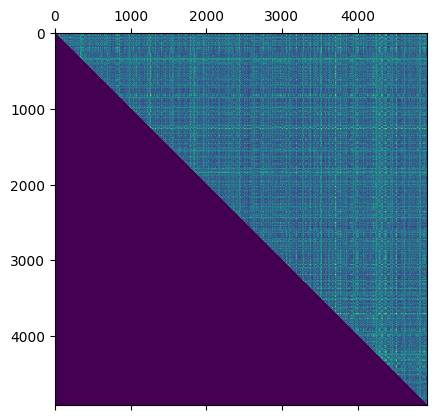

In [22]:
import matplotlib.pyplot as plt

plt.matshow(mat)